# Rainforest Connection Species Audio Detection


## 1. Business Problem

Most of the times sound is much more recognisable and accessible than looking around a massive forest to see certain species and take appropriate action. In this case study, given the audio recordings from tropical rainforest, we are going to detect and classify the sounds of certain species. Not every human is an expert in classifying the sound of various species just by hearing. That is where automatic speech detection is required which can help people in the forests or in certain danger areas to take appropriate actions when required. This can also help in detecting certain human impact on eco system and also to move towards environmental conservation.

## 2. Mapping Business problem to ML problem

Not everybody is an expert to hear a sound and detect which species the sound belong to. Here the use of machine learning comes into picture. We can create ML/DL models with limited but acoustically complex data to automate the detection of species to help everyone who is not expert in this field. We will map this problem as a multi-label classification problem. Here we have to detect the probability of the presence of each species in the given audio file.

## 3. Constraints



*   The latency should be low in this case. We should be able to predict the sound as soon as it is heard so that appropriate action should be taken.
*   Our solution should be able to run on simple devices and must not need high computational power.


*   False negatives should be as low as possible. If there is dangerous species in proximity and the model is not able to detect it then it may cost lives.








## 4. Data

**train_tp.csv** - training data of true positive species labels, with 
corresponding time localization

**train_fp.csv** - training data of false positives species labels, with corresponding time localization

**train/** - the training audio files

**test/** - the test audio files; the task is to predict the species found in each audio file

**tfrecords/{train,test}**- competition data in the TFRecord format, which includes recording_id, audio_wav (encoded in 16-bit PCM format), and label_info (for train only), which provides a,-delimited string of the columns below (minus recording_id), where multiple labels for a recording_id are ;-delimited.

## 5. EDA

We will use train_tp.csv for EDA purpose.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

In [26]:
data_tp= pd.read_csv('/content/drive/MyDrive/Appliedai files/Case_Study_2/train_tp.csv')
data_tp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [3]:
#Basic statistics and info
data_tp.describe()

,species_id,songtype_id,t_min,f_min,t_max,f_max
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,12.023849,1.315789,29.388748,2907.110280,31.925867,6043.157895
std,7.101400,0.921055,17.488898,2528.642227,17.553856,3468.795425
min,0.000000,1.000000,0.026700,93.750000,0.666700,843.750000
25%,6.000000,1.000000,14.164000,947.461000,16.158150,3937.500000
50%,12.000000,1.000000,29.514650,2343.750000,31.869350,5062.500000
75%,18.000000,1.000000,45.257175,3843.750000,48.046800,8250.000000
max,23.000000,4.000000,59.253300,10687.500000,59.994700,13687.500000


In [4]:
data_tp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recording_id  1216 non-null   object 
 1   species_id    1216 non-null   int64  
 2   songtype_id   1216 non-null   int64  
 3   t_min         1216 non-null   float64
 4   f_min         1216 non-null   float64
 5   t_max         1216 non-null   float64
 6   f_max         1216 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 66.6+ KB


In [8]:
data_tp.isna().sum()

recording_id    0
species_id      0
songtype_id     0
t_min           0
f_min           0
t_max           0
f_max           0
dtype: int64

We dont have null or missing values in our data.

Lets see how many unique class labels we have

In [5]:
data_tp['species_id'].unique()

array([14, 23, 12, 17, 10,  8,  0, 18, 15,  1,  6,  7, 11, 13, 16, 19,  3,
        2,  4, 22,  9, 21, 20,  5])

we have 24 unique class labels in our data. Now we will check the distribution of class labels. This will give us an idea if our data is balanced or imbalanced.

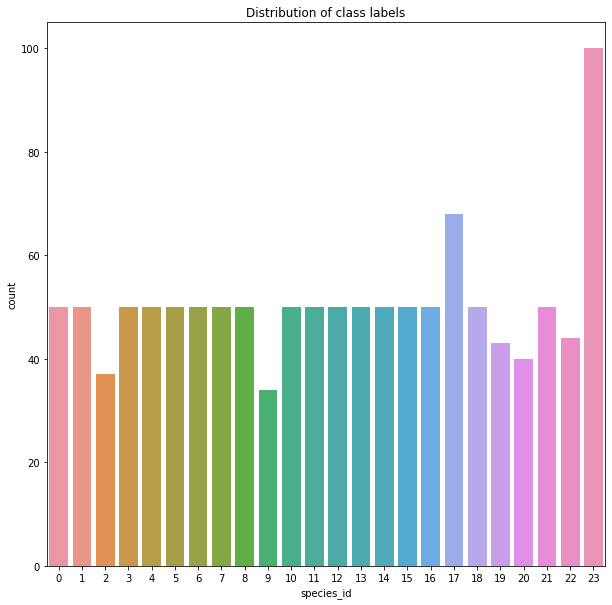

In [11]:
plt.figure(figsize=(10,10))
sns.countplot(x='species_id', data=data_tp)
plt.title('Distribution of class labels')
plt.show()

We have maximum readings for class 23 and minimum readings for class 10. Rest of the classes are pretty much equally distributed.

We need to now check how many species each of the files contain at an average.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of species each recording contains')

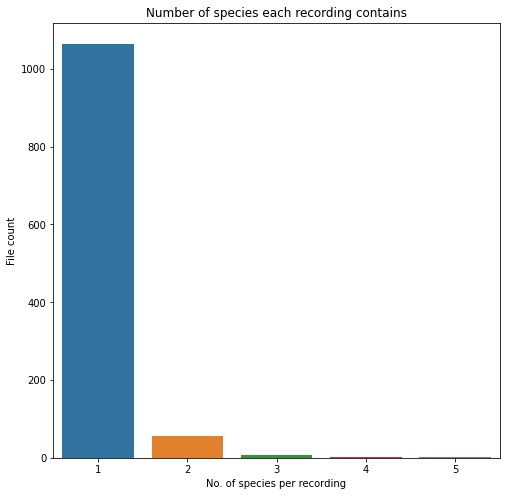

In [12]:
plt.figure(figsize=(8,8))
sns.countplot(data_tp['recording_id'].value_counts())
plt.xlabel('No. of species per recording')
plt.ylabel('File count')
plt.title("Number of species each recording contains")

Most of the recordings in our train data for true positive labels have only 1 species.

**Distribution of t_min and t_max-**


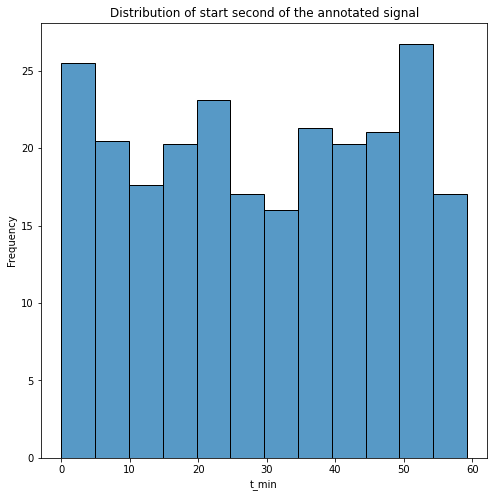

In [15]:
plt.figure(figsize=(8,8))
sns.histplot(data=data_tp, x='t_min', stat='frequency')
plt.title('Distribution of start second of the annotated signal')
plt.show()

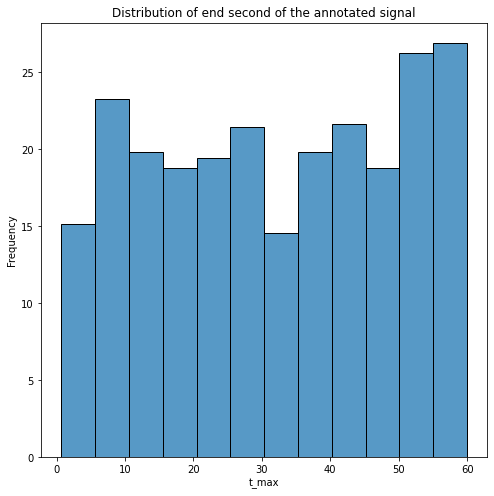

In [16]:
plt.figure(figsize=(8,8))
sns.histplot(data=data_tp, x='t_max', stat='frequency')
plt.title('Distribution of end second of the annotated signal')
plt.show()


Observations:

1. For most of the recordings the start of the annotated signal lies  in 50th-55th second followed by 0th-5th second.

2. For most of the recordings the end of the annotated signal lies  in 55th-60th second followed by 50th-55th second.

3. We can also infer from these plots that our recordings have a average duration of 1 minute.



**Distribution of f_min and f_max-**

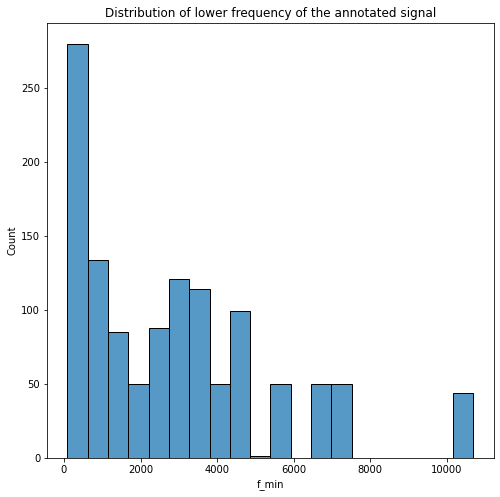

In [19]:
plt.figure(figsize=(8,8))
sns.histplot(data=data_tp, x='f_min')
plt.title('Distribution of lower frequency of the annotated signal')
plt.show()

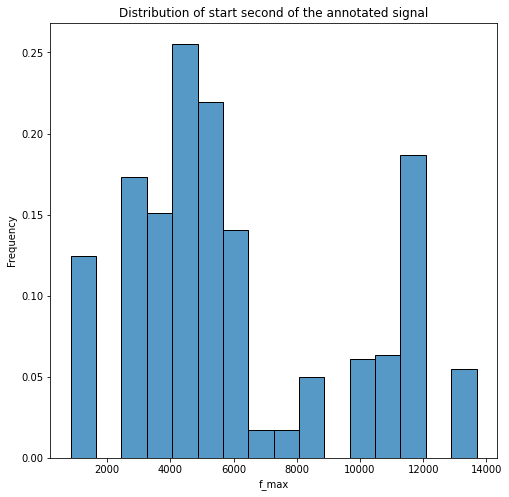

In [21]:
plt.figure(figsize=(8,8))
sns.histplot(data=data_tp, x='f_max', stat='frequency')
plt.title('Distribution of start second of the annotated signal')
plt.show()

Observations:

1. For most of the recordings the lower frequency of the annotated signal lies between 0-800 Hz.

2. For most of the recordings the upper frequncy of the annotated signal lies between 4.2 KHz to 5KHz.

We will check the relation between class labels and lower and upper frequencies.

Text(0.5, 1.0, 'Violin Plot of f_min wrt class labels')

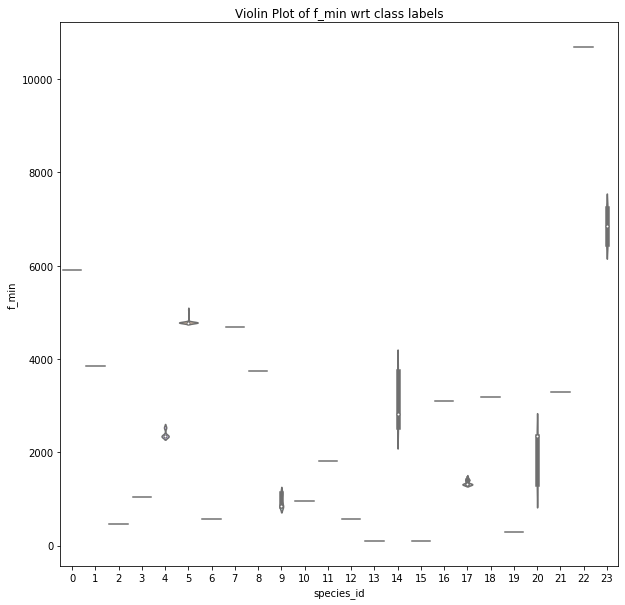

In [23]:
plt.figure(figsize=(10,10))
sns.violinplot(x='species_id', y='f_min', data=data_tp, palette='pastel')
plt.title('Violin Plot of f_min wrt class labels')

Observations-



*  Few classes can be separated on the basis of the f_min values.
*  If f_min lies between 5.5 KHz to 5.8 KHz then the species belong to class 0.

*  If f_min is greater than 10 KHz then the species belong to class 22
*  If f_min lies between 6 KHz to 7.8 KHz then the species belong to class 23.

*  If f_min lies between 4.8 KHz to 5.6 Khz then the species belong to class 5. 

*  Class 13 and 15 are not separable on the basis of lower frequencies.

*  Most of the class of species have very narrow range of lower frequencies.












Text(0.5, 1.0, 'Violin Plot of f_max wrt class labels')

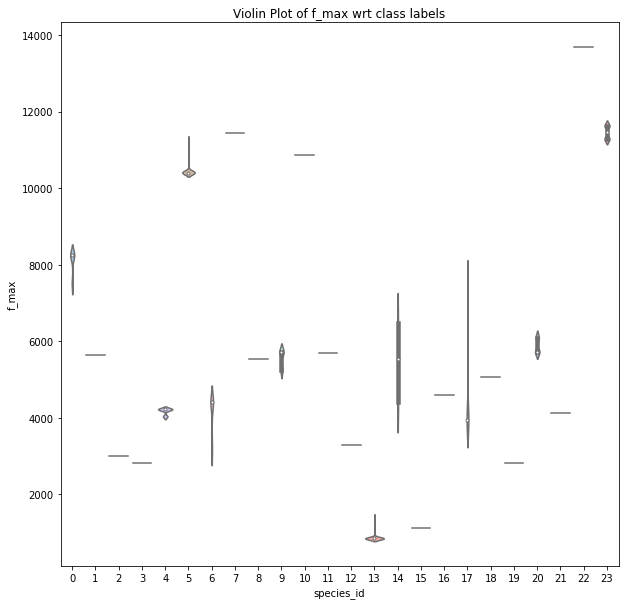

In [24]:
plt.figure(figsize=(10,10))
sns.violinplot(x='species_id', y='f_max', data=data_tp, palette='pastel')
plt.title('Violin Plot of f_max wrt class labels')

Observations-



*  Few classes can be separated on the basis of the f_max values.
* Class 2 and 3 are easily separable from each other.

* Class 14 and 17 have a very broad range of values and might contain a few outliers.
* If f_max is greater than 12 KHz then data belongs to class 22.


